# Association Rule Mining pe setul de date Weightlifting


In [1]:
import pandas as pd
from mlxtend.preprocessing  import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../DataSet/weightlifting_721_workouts.csv')

transactions = (
    df.groupby('Workout Name')['Exercise Name']
      .apply(lambda x: list(x.unique()))
      .tolist()
)

te     = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

min_support    = 0.05
min_confidence = 0.30

freq_items = apriori(df_trans, min_support=min_support, use_colnames=True)
rules      = association_rules(freq_items, metric='confidence', min_threshold=min_confidence)

freq_items_fp = fpgrowth(df_trans, min_support=min_support, use_colnames=True)
rules_fp      = association_rules(freq_items_fp, metric='confidence', min_threshold=min_confidence)


### Cele mai frecvente itemset-uri (Algoritmul Apriori)
Acest grafic afiseaza top 10 seturi de item-uri cu cel mai mare suport.

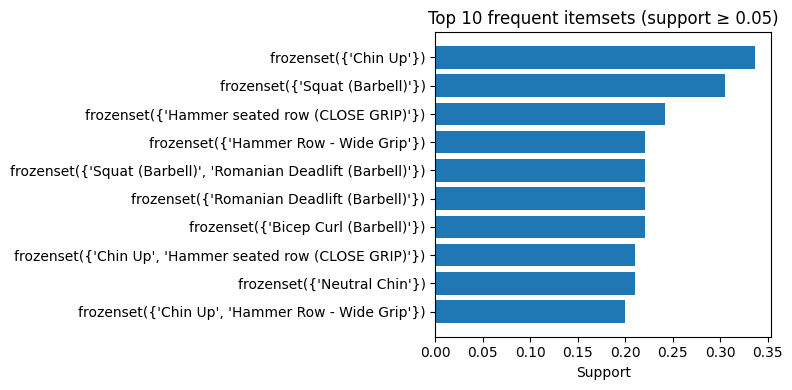

In [ ]:
# Plot 1: Top 10 frequent itemsets (Bar chart orizontal)
top10_items = freq_items.sort_values('support', ascending=False).head(10)
plt.figure(figsize=(8,4))
plt.barh(top10_items['itemsets'].astype(str), top10_items['support'])
plt.xlabel('Support')
plt.title(f'Top 10 seturi de itemi frecventi (suport ≥ {min_support})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Concluzie:**
- Exercitiul 'Chin Up' apare cel mai frecvent (~34%), urmat de 'Squat (Barbell)' (~32%).
- Majoritatea itemset-urilor frecvente sunt unare, indicând ca utilizatorii efectueaza adesea aceste exercitii individual.

## 2. Algoritmul Apriori

Vom folosi `mlxtend.frequent_patterns.apriori` pentru a extrage frequent itemsets cu un prag minim de suport, apoi vom genera reguli de asociatie cu prag minim de confidence.

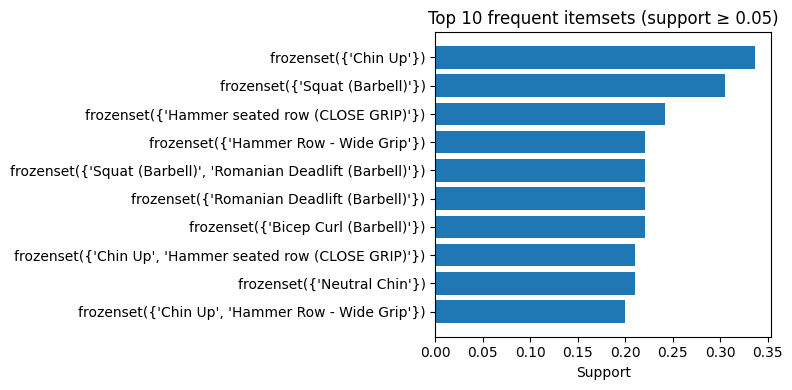

In [ ]:
top10_items = freq_items.sort_values('support', ascending=False).head(10)

plt.figure(figsize=(8,4))
plt.barh(
    top10_items['itemsets'].astype(str),
    top10_items['support']
)
plt.xlabel('Support')
plt.title(f'Top 10 seturi de itemi frecventi (suport ≥ {min_support})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Majoritatea ­itemset-urilor din top 10 sunt singleton-uri (o singura miscare). Doar doua sunt perechi de exercitii („Romanian Deadlift + Squat” si „Hammer Row + Chin Up”), ceea ce inseamna ca, deşi exista şi câteva combinatii frecvente, sportivii tind sa execute in mod repetat in principal exerciţii izolate.

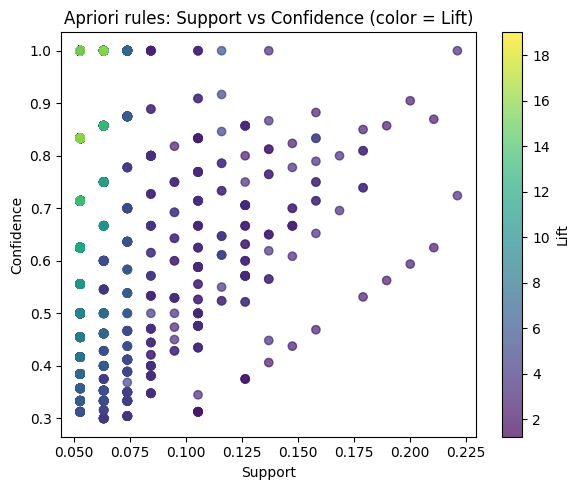

In [ ]:
plt.figure(figsize=(6,5))
sc = plt.scatter(
    rules['support'],
    rules['confidence'],
    c=rules['lift'],
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(sc, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Reguli Apriori: Suport vs Incredere (culoare = Lift)')
plt.tight_layout()
plt.show()


Observam o densitate mare de reguli in zona de suport redus (5–10%) si confidence mediu–ridicat (0.6–0.9).

Regulile cu confidence aproape de 1 (adica antecedentul implica consecventul de fiecare data) apar pe un interval variabil de suport, de la 5% pâna la ~22%.

Lift-ul maxim (≈19) se gaseste pentru acele reguli rare (support mic) care totusi au confidence perfecta—adica, in acel mic subset de sesiuni, prezenţa anumitor exerciţii „asigura” prezenţa altora de fiecare data.

in general, exista un trade-off: cu cât o regula are suport mai mare, cu atât lift-ul tinde sa scada, iar confidence-ul devine mai variabil.

## 3. Algoritmul FP-Growth

FP-Growth este o varianta eficienta care construieste un FP-tree si extrage direct frequent itemsets.

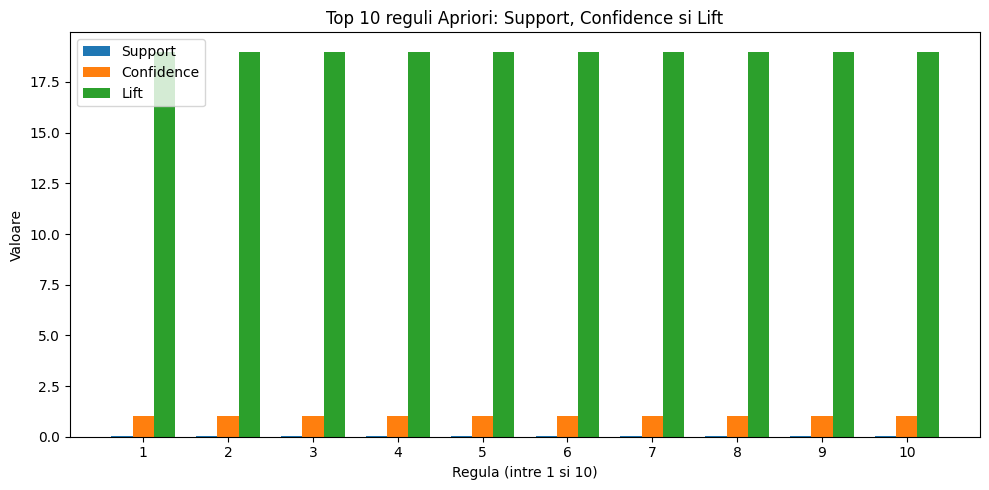

Legenda regulilor:
1: {'Chin Up', 'Hammer seated row (CLOSE GRIP)', 'Bent Over Row (Dumbbell)'} → {'Seated Cable Row (close Grip)', 'Neutral Chin', 'Face pull', 'Bicep Curl (Barbell)'}
2: {'Seated Cable Row (close Grip)', 'Chin Up', 'Face pull', 'Bicep Curl (Barbell)'} → {'Neutral Chin', 'Bent Over Row (Dumbbell)'}
3: {'Seated Cable Row (close Grip)', 'Face pull'} → {'Bent Over Row (Dumbbell)', 'Hammer seated row (CLOSE GRIP)', 'Bicep Curl (Barbell)'}
4: {'Hammer seated row (CLOSE GRIP)', 'Seated Cable Row (close Grip)', 'Chin Up', 'Face pull'} → {'Neutral Chin', 'Bent Over Row (Dumbbell)', 'Bicep Curl (Barbell)'}
5: {'Seated Cable Row (close Grip)', 'Face pull'} → {'Neutral Chin', 'Bent Over Row (Dumbbell)'}
6: {'Seated Cable Row (close Grip)', 'Neutral Chin', 'Chin Up', 'Face pull'} → {'Bent Over Row (Dumbbell)', 'Hammer seated row (CLOSE GRIP)'}
7: {'Seated Shoulder  Press (Barbell)', 'Shoulder Press (Standing)', 'Lateral Raise (Dumbbells)', 'Incline Press (Dumbbell)'} → {'Weighted 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

top10 = (
    rules[['antecedents','consequents','support','confidence','lift']]
         .sort_values('lift', ascending=False)
         .head(10)
).reset_index(drop=True)

indices = np.arange(1, len(top10)+1)

supports   = top10['support']
confidences = top10['confidence']
lifts      = top10['lift']

width = 0.25

plt.figure(figsize=(10,5))
plt.bar(indices - width, supports,    width, label='Support')
plt.bar(indices,         confidences,width, label='Confidence')
plt.bar(indices + width, lifts,      width, label='Lift')

plt.xlabel('Regula (intre 1 si 10)')
plt.ylabel('Valoare')
plt.title('Top 10 reguli Apriori: Suport, Incredere si Lift')
plt.xticks(indices)
plt.legend()
plt.tight_layout()
plt.show()

print("Legenda regulilor:")
for i, row in top10.iterrows():
    print(f"{i+1}: {set(row['antecedents'])} → {set(row['consequents'])}")


# concluzei

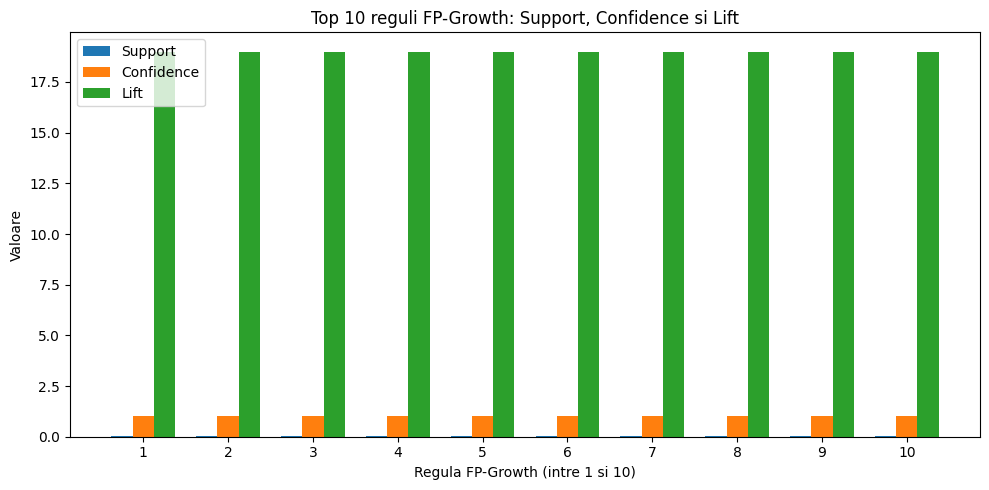

Legenda regulilor FP-Growth:
1: {'Shoulder Press (Standing)', 'Incline Press (Dumbbell)'} → {'Bench Press (Barbell)', 'Lateral Raise (Dumbbells)', 'Tricep pushdown'}
2: {'Bench Press (Barbell)', 'Lateral Raise (Dumbbells)', 'Tricep pushdown'} → {'Shoulder Press (Standing)', 'Incline Press (Dumbbell)'}
3: {'Lateral Raise (Dumbbells)', 'Shoulder Press (Standing)'} → {'Bench Press (Barbell)', 'Tricep pushdown', 'Incline Press (Dumbbell)'}
4: {'Tricep pushdown', 'Shoulder Press (Standing)'} → {'Bench Press (Barbell)', 'Lateral Raise (Dumbbells)', 'Incline Press (Dumbbell)'}
5: {'Lateral Raise (Dumbbells)', 'Shoulder Press (Standing)'} → {'Seated Shoulder  Press (Barbell)', 'Bench Press (Barbell)', 'Incline Press (Dumbbell)'}
6: {'Seated Shoulder  Press (Barbell)', 'Bench Press (Barbell)', 'Tricep pushdown', 'Incline Press (Dumbbell)'} → {'Lateral Raise (Dumbbells)', 'Shoulder Press (Standing)'}
7: {'Shoulder Press (Standing)', 'Lateral Raise (Dumbbells)', 'Incline Press (Dumbbell)'} → {'We

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Pregatim top10_fp
top10_fp = (
    rules_fp[['antecedents','consequents','support','confidence','lift']]
    .sort_values('lift', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# 2. Indici 1…10 pentru regulile FP-Growth
indices = np.arange(1, len(top10_fp) + 1)

# 3. Extragem valorile
supports_fp    = top10_fp['support']
confidences_fp = top10_fp['confidence']
lifts_fp       = top10_fp['lift']

# 4. Latimea barelor
width = 0.25

# 5. Desenam graficul
plt.figure(figsize=(10,5))
plt.bar(indices - width, supports_fp,    width, label='Support')
plt.bar(indices,         confidences_fp, width, label='Confidence')
plt.bar(indices + width, lifts_fp,       width, label='Lift')

plt.xlabel('Regula FP-Growth (intre 1 si 10)')
plt.ylabel('Valoare')
plt.title('Top 10 reguli FP-Growth: Suport, Incredere si Lift')
plt.xticks(indices)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Legenda textuala
print("Legenda regulilor FP-Growth:")
for i, row in top10_fp.iterrows():
    print(f"{i+1}: {set(row['antecedents'])} → {set(row['consequents'])}")



## 4. Vizualizari si interpretare
* Vizualizare top 10 frequent itemsets
* Scatter plot suport vs. confidence pentru reguli Apriori

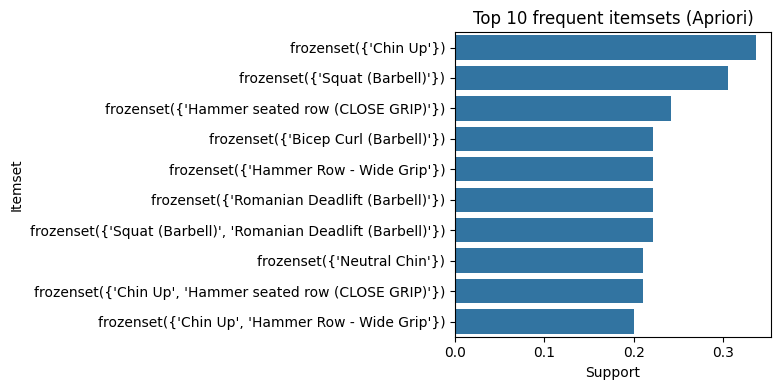

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4.1 Bar chart top 10 frequent itemsets (Apriori)
top_items = freq_items.nlargest(10, 'support')
plt.figure(figsize=(8,4))
sns.barplot(x='support', y=top_items['itemsets'].astype(str), data=top_items)
plt.title('Top 10 seturi de itemi frecventi (Apriori)')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.tight_layout()
plt.show()

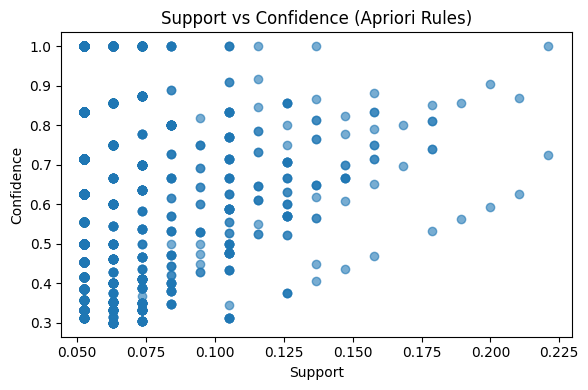

In [8]:
# 4.2 Scatter: support vs. confidence pentru Apriori rules
plt.figure(figsize=(6,4))
plt.scatter(rules['support'], rules['confidence'], alpha=0.6)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Suport vs Incredere (Reguli Apriori)')
plt.tight_layout()
plt.show()

## 5. Concluzii si insight-uri
- Numarul sesiunilor si frecventa exercitiilor relevante.
- Reguli de asociatie care indica, de exemplu, ca daca se face **Squat**, exista o probabilitate mare sa se includa si **Bench Press** in aceeasi sesiune (exemplu ipotetic).
- Compararea Apriori vs FP-Growth in termeni de numar de itemsets si eficienta.